In [7]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import math

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# warnings.filterwarnings('ignore')

In [8]:
from data import train_test_data, read_settings, normalize, tf_dataframe
settings = read_settings()
train, test = train_test_data(settings)

In [9]:
data = pd.concat((train, test))
data = data[['dayofweek','weekday','(02000) cabecera autopista norte']]
mean = data['(02000) cabecera autopista norte'].mean()
std = data['(02000) cabecera autopista norte'].std()
data['(02000) cabecera autopista norte'] = (data['(02000) cabecera autopista norte'] - mean)/std
df = data

In [295]:
df = data.filter(items = [2015, 8], axis=0)

In [305]:
df.index.get_loc((2015, 9, 1))

31

<AxesSubplot:>

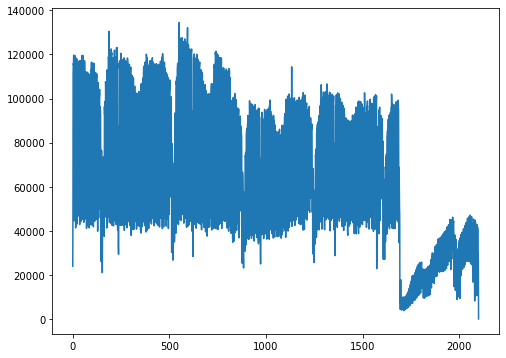

In [292]:
data['(02000) cabecera autopista norte'].plot()

In [44]:
input_ = tf.keras.utils.timeseries_dataset_from_array(
      data=data[:-14],
      targets=None,
      sequence_length=14,
      sequence_stride=1,
      shuffle=False,
      batch_size=3,)

In [45]:
for row in input_.take(1):
  print(row)

tf.Tensor(
[[[2.39120e+04 5.00000e+00 0.00000e+00]
  [4.71970e+04 6.00000e+00 0.00000e+00]
  [1.10704e+05 0.00000e+00 1.00000e+00]
  [1.15831e+05 1.00000e+00 1.00000e+00]
  [1.15422e+05 2.00000e+00 1.00000e+00]
  [1.19695e+05 3.00000e+00 1.00000e+00]
  [4.70220e+04 4.00000e+00 1.00000e+00]
  [6.97220e+04 5.00000e+00 0.00000e+00]
  [4.44800e+04 6.00000e+00 0.00000e+00]
  [1.16179e+05 0.00000e+00 1.00000e+00]
  [1.17085e+05 1.00000e+00 1.00000e+00]
  [1.17729e+05 2.00000e+00 1.00000e+00]
  [1.16898e+05 3.00000e+00 1.00000e+00]
  [1.19356e+05 4.00000e+00 1.00000e+00]]

 [[4.71970e+04 6.00000e+00 0.00000e+00]
  [1.10704e+05 0.00000e+00 1.00000e+00]
  [1.15831e+05 1.00000e+00 1.00000e+00]
  [1.15422e+05 2.00000e+00 1.00000e+00]
  [1.19695e+05 3.00000e+00 1.00000e+00]
  [4.70220e+04 4.00000e+00 1.00000e+00]
  [6.97220e+04 5.00000e+00 0.00000e+00]
  [4.44800e+04 6.00000e+00 0.00000e+00]
  [1.16179e+05 0.00000e+00 1.00000e+00]
  [1.17085e+05 1.00000e+00 1.00000e+00]
  [1.17729e+05 2.00000e+00 

In [48]:
target = tf.keras.utils.timeseries_dataset_from_array(
      data=data[14:,0],
      targets=None,
      sequence_length=7,
      sequence_stride=1,
      shuffle=False,
      batch_size=3,)

In [49]:
for row in target.take(1):
  print(row)

tf.Tensor(
[[ 81065.  41323.  42998. 118358. 116541. 117910. 115881.]
 [ 41323.  42998. 118358. 116541. 117910. 115881.  81662.]
 [ 42998. 118358. 116541. 117910. 115881.  81662.  43079.]], shape=(3, 7), dtype=float32)


In [50]:
for batch in zip(input_, target):
  inputs, targets = batch

In [55]:
targets

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[84998., 87905., 38203., 54666., 39475., 86076., 85034.],
       [87905., 38203., 54666., 39475., 86076., 85034., 85431.],
       [38203., 54666., 39475., 86076., 85034., 85431., 84854.]],
      dtype=float32)>

In [89]:
df = pd.DataFrame({'a': range(0,1000), 'b': range(1000,2000), 'c': range(2000,3000)})

In [90]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


In [3]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               data, label_columns=None, train_date=(2018,8,1), 
               val_date=(2018, 9, 1), batch_size=32):
    # Store the raw data.
    self.batch_size = batch_size
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    train_index = data.index.get_loc(train_date)
    val_index = data.index.get_loc(val_date) 

    self.train_df = data.iloc[:train_index]
    self.val_df = data.iloc[train_index - input_width: val_index]
    self.test_df = data.iloc[val_index  - input_width:]

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(data.columns)}

    # Work out the window parameters.
    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, 
      batch_size= self.batch_size)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [651]:
dataset = tf.data.Dataset.range(50)
dataset = dataset.skip(7).take(10).batch(3)
list(dataset.as_numpy_iterator())

[array([7, 8, 9]), array([10, 11, 12]), array([13, 14, 15]), array([16])]

In [652]:
w1 = WindowGenerator(input_width=14, label_width=7, shift=7, data = df,
                     label_columns=['(02000) cabecera autopista norte'])

In [643]:
w1.train_index

AttributeError: 'WindowGenerator' object has no attribute 'train_index'

In [653]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 3)
Labels shape (batch, time, features): (32, 7, 1)


In [584]:
dataset_length = [i for i,_ in enumerate(w1.make_dataset(df))][-1] + 1
dataset_length

2081

In [623]:
dataset_length = [i for i,_ in enumerate(w1.train)][-1] + 1
dataset_length

34

In [624]:
dataset_length = [i for i,_ in enumerate(w1.val)][-1] + 1
dataset_length

1

In [625]:
dataset_length = [i for i,_ in enumerate(w1.test)][-1] + 1
dataset_length

31

In [660]:
# val_date = (2018,8,1)
# val_index = df.index.get_loc(val_date) 
# test = df.iloc[val_index - 14:]
# test.head(50)

In [659]:
# for example_inputs, example_labels in w1.val.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs}')
#   print(f'Labels shape (batch, time, features): {example_labels}')

In [560]:
dataset_length = [i for i,_ in enumerate(w1.train)][-1] + 1
dataset_length

34

In [561]:
train

In [202]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 3, 1)


In [239]:
w1.train.element_spec

(TensorSpec(shape=(None, 14, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None))

In [204]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (2, 6, 3)
Labels shape (batch, time, features): (2, 3, 1)


In [205]:
for example_inputs, example_labels in w2.val.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs}')
  print(f'Labels shape (batch, time, features): {example_labels}')

Inputs shape (batch, time, features): [[[ 700. 1700. 2700.]
  [ 701. 1701. 2701.]
  [ 702. 1702. 2702.]
  [ 703. 1703. 2703.]
  [ 704. 1704. 2704.]
  [ 705. 1705. 2705.]]

 [[ 701. 1701. 2701.]
  [ 702. 1702. 2702.]
  [ 703. 1703. 2703.]
  [ 704. 1704. 2704.]
  [ 705. 1705. 2705.]
  [ 706. 1706. 2706.]]]
Labels shape (batch, time, features): [[[1704.]
  [1705.]
  [1706.]]

 [[1705.]
  [1706.]
  [1707.]]]


# Neural Networks

In [4]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      verbose = True)
  return history

## Convolutional neural network

In [35]:
CONV_WIDTH = 14
num_features = 1
OUT_STEPS = 7
w1 = WindowGenerator(input_width=14, label_width=OUT_STEPS, shift=OUT_STEPS, data = df,
                     label_columns=['(02000) cabecera autopista norte'], batch_size = 32, 
                     train_date=(2018,8,1), val_date=(2018, 9, 1))
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20]
Label column name(s): ['(02000) cabecera autopista norte']

In [39]:
df.iloc[df.index.get_loc((2018,9,1)):].head(20)
df.iloc[0:].head(20)
df.iloc[df.index.get_loc((2018,9,1)):].head(20)

dayofweek  weekday  (02000) cabecera autopista norte
year month day                                                      
2018 9     1            5        0                         -0.030295
           2            6        0                         -0.872788
           3            0        1                          0.725662
           4            1        1                          0.750568
           5            2        1                          0.614899
           6            3        1                          0.441000
           7            4        1                          1.196928
           8            5        0                         -0.056206
           9            6        0                         -0.939529
           10           0        1                          0.693074
           11           1        1                          0.686309
           12           2        1                          0.707197
           13           3        1                          0.675023
           14           4        1                          0.763095
           15           5        0                         -0.053871
           16           6        0                         -0.863570
           17           0        1                          0.655907
           18           1        1                          0.703208
           19           2        1                          0.666277
           20           3        1                          0.652096

In [38]:
for example_inputs, example_labels in w1.test.take(1):
  # print(f'Inputs shape (batch, time, features): {example_inputs}')
  print(f'Labels shape (batch, time, features): {example_labels}')

Labels shape (batch, time, features): [[[-0.03029493]
  [-0.87278795]
  [ 0.72566205]
  [ 0.75056815]
  [ 0.61489946]
  [ 0.4410001 ]
  [ 1.1969275 ]]

 [[-0.87278795]
  [ 0.72566205]
  [ 0.75056815]
  [ 0.61489946]
  [ 0.4410001 ]
  [ 1.1969275 ]
  [-0.05620552]]

 [[ 0.72566205]
  [ 0.75056815]
  [ 0.61489946]
  [ 0.4410001 ]
  [ 1.1969275 ]
  [-0.05620552]
  [-0.9395292 ]]

 [[ 0.75056815]
  [ 0.61489946]
  [ 0.4410001 ]
  [ 1.1969275 ]
  [-0.05620552]
  [-0.9395292 ]
  [ 0.6930744 ]]

 [[ 0.61489946]
  [ 0.4410001 ]
  [ 1.1969275 ]
  [-0.05620552]
  [-0.9395292 ]
  [ 0.6930744 ]
  [ 0.6863087 ]]

 [[ 0.4410001 ]
  [ 1.1969275 ]
  [-0.05620552]
  [-0.9395292 ]
  [ 0.6930744 ]
  [ 0.6863087 ]
  [ 0.7071967 ]]

 [[ 1.1969275 ]
  [-0.05620552]
  [-0.9395292 ]
  [ 0.6930744 ]
  [ 0.6863087 ]
  [ 0.7071967 ]
  [ 0.67502266]]

 [[-0.05620552]
  [-0.9395292 ]
  [ 0.6930744 ]
  [ 0.6863087 ]
  [ 0.7071967 ]
  [ 0.67502266]
  [ 0.763095  ]]

 [[-0.9395292 ]
  [ 0.6930744 ]
  [ 0.6863087 ]
  

In [19]:
## TO DO: 
## Get the actual implementation for multiple outputs
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [20]:
history = compile_and_fit(multi_conv_model, w1)

Epoch 1/20
34/34 [==============================] - 1s 7ms/step - loss: 0.5330 - mean_absolute_error: 0.5830 - val_loss: 0.1937 - val_mean_absolute_error: 0.3277
Epoch 2/20
34/34 [==============================] - 0s 4ms/step - loss: 0.3490 - mean_absolute_error: 0.4395 - val_loss: 0.1428 - val_mean_absolute_error: 0.2958
Epoch 3/20
34/34 [==============================] - 0s 4ms/step - loss: 0.3108 - mean_absolute_error: 0.4057 - val_loss: 0.1269 - val_mean_absolute_error: 0.2611
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2735 - mean_absolute_error: 0.3609 - val_loss: 0.1126 - val_mean_absolute_error: 0.2266
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2551 - mean_absolute_error: 0.3361 - val_loss: 0.1090 - val_mean_absolute_error: 0.2168
Epoch 6/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2413 - mean_absolute_error: 0.3158 - val_loss: 0.1081 - val_mean_absolute_error: 0.2147
Epoch 7/20
34/34 [==========

In [22]:
prediction = multi_conv_model.predict(w1.test)

In [28]:
prediction[0]

array([[ 0.5154574 ],
       [ 0.5685845 ],
       [-0.17964496],
       [-0.99001515],
       [ 0.2956371 ],
       [ 0.58719724],
       [ 0.586471  ]], dtype=float32)

In [32]:
prediction[0]

array([[ 0.5154574 ],
       [ 0.5685845 ],
       [-0.17964496],
       [-0.99001515],
       [ 0.2956371 ],
       [ 0.58719724],
       [ 0.586471  ]], dtype=float32)

In [31]:
prediction.reshape((907, 7))

array([[ 0.5154574 ,  0.5685845 , -0.17964496, ...,  0.2956371 ,
         0.58719724,  0.586471  ],
       [ 0.5492369 , -0.19462383, -1.0012038 , ...,  0.59493226,
         0.60057825,  0.5538131 ],
       [-0.20751888, -1.0126997 ,  0.28648305, ...,  0.596973  ,
         0.5507713 ,  0.57015485],
       ...,
       [ 0.08184681, -0.19968712, -0.5274714 , ...,  0.2195263 ,
         0.23125388,  0.21915556],
       [-0.286252  , -0.5881661 ,  0.07155177, ...,  0.21396534,
         0.17940313,  0.18948688],
       [-0.597405  ,  0.01019074,  0.15183105, ...,  0.1623775 ,
         0.2062358 , -0.12917067]], dtype=float32)

In [667]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [668]:
for example_inputs, example_labels in w1.val.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 3)
Labels shape (batch, time, features): (32, 7, 1)


In [669]:
history = compile_and_fit(multi_lstm_model, w1)

Epoch 1/20
34/34 [==============================] - 3s 18ms/step - loss: 0.8217 - mean_absolute_error: 0.7845 - val_loss: 0.4079 - val_mean_absolute_error: 0.5070
Epoch 2/20
34/34 [==============================] - 0s 7ms/step - loss: 0.7068 - mean_absolute_error: 0.7073 - val_loss: 0.4048 - val_mean_absolute_error: 0.4856
Epoch 3/20
34/34 [==============================] - 0s 7ms/step - loss: 0.6761 - mean_absolute_error: 0.6921 - val_loss: 0.3821 - val_mean_absolute_error: 0.4748
Epoch 4/20
34/34 [==============================] - 0s 7ms/step - loss: 0.6427 - mean_absolute_error: 0.6713 - val_loss: 0.3610 - val_mean_absolute_error: 0.4572
Epoch 5/20
34/34 [==============================] - 0s 8ms/step - loss: 0.6068 - mean_absolute_error: 0.6485 - val_loss: 0.3391 - val_mean_absolute_error: 0.4414
Epoch 6/20
34/34 [==============================] - 0s 7ms/step - loss: 0.5704 - mean_absolute_error: 0.6244 - val_loss: 0.3172 - val_mean_absolute_error: 0.4278
Epoch 7/20
34/34 [=========